In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import sklearn
# import matplotlib.pyplot as plt
import seaborn as sns
import tableone
from utils import quick_load_liuzhong_health_check_data
from plot_utils import plt

%matplotlib inline


warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_groups, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/"

In [6]:
def get_table_one_months(df_table1plus_3p_revMM, l_months=[12,1,2]):
    df_sub = df_table1plus_3p_revMM[df_table1plus_3p_revMM["month"].isin(l_months)][
         l_basics+["period"] + l_columns+l_category
    ]

    l_cat_en = l_category[0:1] + list(df_meta_groups.loc[l_category[1:]]["item_name_en"])
    l_col_en = list(df_meta_groups.loc[l_columns]["item_name_en"])
    df_sub.columns = l_basics_en + [ "period"] + l_col_en + l_cat_en

    mytable = tableone.TableOne(df_sub, 
                                l_basics_en + l_col_en+l_cat_en,
                                ["gender"]+l_cat_en, 
                                groupby="period", 
                                pval=True, 
                                overall=False, missing=False, pval_adjust="bonferroni")
    return mytable

l_basics = ["gender", "age", "v000760", "v000761", "v002266"]
l_basics_en = ["gender", "age", "height", "weight", " waist-circumference"]
l_high_lighted = list(df_meta_groups["item_id"])
l_columns = list(filter(lambda x: x[0]=="v", l_high_lighted))
l_category = list(filter(lambda x: x[0]!="v", l_high_lighted))
l_col_en = list(df_meta_groups.loc[l_columns]["item_name_en"])

my_table_pre = get_table_one_months(df_table1plus_3p_revMM, l_months=[11, 12])
my_table_ = get_table_one_months(df_table1plus_3p_revMM, l_months=[1,2,3])
my_table_after = get_table_one_months(df_table1plus_3p_revMM, l_months=[4,5,6])

In [9]:
def get_ratio(my_table):
    df_mean = my_table.cont_describe["mean"]
    np_ratio = df_mean.apply(lambda x: 2*x["Test-2023"] / (x["Control-2021"]+x["Control-2022"]), axis=1)
    return np_ratio#.reset_index()

df_res = get_ratio(my_table_pre).reset_index()
l_hue_orders = ["2022q4 vs mean(2020,2021) q4", "2023q1 vs mean(2021,2022) q1", "2023q2 vs mean(2021,2022) q2"]
df_res.columns = ["items", l_hue_orders[0]]
df_res[l_hue_orders[1]] = get_ratio(my_table_).values
df_res[l_hue_orders[2]] = get_ratio(my_table_after).values
df_res.index = list(df_res["items"])
l_tags = l_basics_en[2:]+l_col_en
df_ratio = pd.melt(df_res.loc[l_tags], id_vars="items")
df_ratio

,items,variable,value
0,height,"2022q4 vs mean(2020,2021) q4",1.000537
1,weight,"2022q4 vs mean(2020,2021) q4",1.003806
2,waist-circumference,"2022q4 vs mean(2020,2021) q4",0.988433
3,HR,"2022q4 vs mean(2020,2021) q4",0.998004
4,HCY,"2022q4 vs mean(2020,2021) q4",0.988347
...,...,...,...
148,TBIL,"2023q2 vs mean(2021,2022) q2",0.971758
149,DBIL,"2023q2 vs mean(2021,2022) q2",0.970983
150,IBIL,"2023q2 vs mean(2021,2022) q2",0.972120
151,TBA,"2023q2 vs mean(2021,2022) q2",1.117048


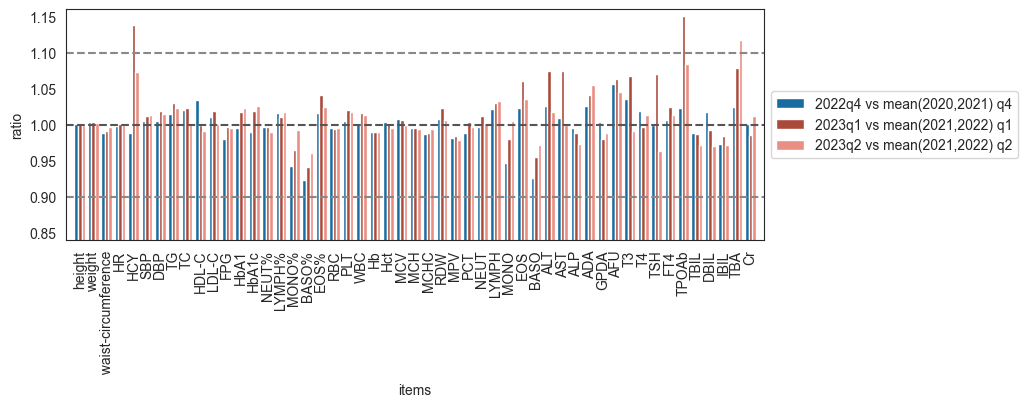

In [14]:
my_pal = ["#0172B6", "#BD3C29", "#fb8072"]
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,1,1)
sns.barplot(data=df_ratio, x="items", y="value", hue="variable", hue_order=l_hue_orders, palette=my_pal, ax=ax)
ax.set_ylim((0.84, 1.16))
ax.set_xlim((-1, len(l_tags)))
ax.hlines(0.9, -1, 100, linestyles="dashed", color="#888888")
ax.hlines(1.0, -1, 100, linestyles="dashed", color="#555555")
ax.hlines(1.1, -1, 100, linestyles="dashed", color="#888888")
ax.set_xticks(np.arange(len(l_tags)))
ax.set_xticklabels(l_tags, rotation=90)
ax.set_title("")
ax.set_ylabel("ratio")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(f"{workdir}/figures/Figure1_G_rev.pdf")